In [18]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [19]:
df = pd.read_csv(r'D:\study\computational_ds\project\data\clean_sample_data.csv')

In [20]:
# Function to map stars to sentiment
def map_sentiment(stars_received):
    if stars_received <= 2:
        return -1
    elif stars_received == 3:
        return 0
    else:
        return 1
# Mapping stars to sentiment into three categories
df['sentiment'] = [ map_sentiment(x) for x in df['overall']]

In [21]:
df = df.dropna()

## packages

In [22]:
reviews = df['Clean_Review']

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Calculate TF-IDF using scikit-learn TfidfVectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(reviews)

# Convert TF-IDF matrix to a dense NumPy array
tfidf_array = tfidf_matrix.toarray()

In [48]:
num_components = 2  # Choose the number of components
pca = PCA(n_components=num_components)
tfidf_pca = pca.fit_transform(tfidf_array)

In [27]:
import time
import psutil

In [29]:
def kmeans(X, k, max_iters=100, tol=1e-4):
    """
    K-means clustering algorithm.

    Parameters:
    - X: numpy array, shape (n_samples, n_features)
        The input data.
    - k: int
        Number of clusters.
    - max_iters: int, optional, default: 100
        Maximum number of iterations.
    - tol: float, optional, default: 1e-4
        Tolerance to declare convergence.

    Returns:
    - centroids: numpy array, shape (k, n_features)
        Final cluster centers.
    - labels: numpy array, shape (n_samples,)
        Index of the cluster each sample belongs to.
    - runtime: float
        Execution time in seconds.
    - cpu_percent: float
        Average CPU usage percentage.
    """
    start_time = time.time()
    
    # Randomly initialize centroids
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]

    for _ in range(max_iters):
        # Assign each data point to the nearest centroid
        labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2), axis=1)

        # Update centroids
        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])

        # Check for convergence
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    end_time = time.time()
    runtime = end_time - start_time

    # Calculate average CPU usage percentage during the algorithm execution
    cpu_percent = psutil.cpu_percent(interval=1)

    return centroids, labels, runtime, cpu_percent

def mini_batch_kmeans(X, k, batch_size=100, max_iters=100, tol=1e-4):
    """
    Mini-batch K-means clustering algorithm.

    Parameters:
    - X: numpy array, shape (n_samples, n_features)
        The input data.
    - k: int
        Number of clusters.
    - batch_size: int, optional, default: 100
        Number of samples to use in each iteration.
    - max_iters: int, optional, default: 100
        Maximum number of iterations.
    - tol: float, optional, default: 1e-4
        Tolerance to declare convergence.

    Returns:
    - centroids: numpy array, shape (k, n_features)
        Final cluster centers.
    - labels: numpy array, shape (n_samples,)
        Index of the cluster each sample belongs to.
    - runtime: float
        Execution time in seconds.
    - cpu_percent: float
        Average CPU usage percentage.
    """
    start_time = time.time()
    # Randomly initialize centroids
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]

    for _ in range(max_iters):
        # Randomly select a mini-batch
        batch_indices = np.random.choice(X.shape[0], batch_size, replace=False)
        X_batch = X[batch_indices]

        # Assign each data point in the mini-batch to the nearest centroid
        labels_batch = np.argmin(np.linalg.norm(X_batch[:, np.newaxis] - centroids, axis=2), axis=1)

        # Update centroids based on the mini-batch
        for j in range(k):
            if np.sum(labels_batch == j) > 0:
                centroids[j] = np.mean(X_batch[labels_batch == j], axis=0)

        # Check for convergence
        if np.linalg.norm(X_batch[labels_batch] - centroids[labels_batch]) < tol:
            break

    # Assign each data point to the nearest centroid using the updated centroids
    labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2), axis=1)

    end_time = time.time()
    runtime = end_time - start_time

    # Calculate average CPU usage percentage during the algorithm execution
    cpu_percent = psutil.cpu_percent(interval=1)

    return centroids, labels, runtime, cpu_percent

def kmeans_plusplus(X, k, max_iters=100, tol=1e-4):
    """
    K-means++ clustering algorithm.

    Parameters:
    - X: numpy array, shape (n_samples, n_features)
        The input data.
    - k: int
        Number of clusters.
    - max_iters: int, optional, default: 100
        Maximum number of iterations.
    - tol: float, optional, default: 1e-4
        Tolerance to declare convergence.

    Returns:
    - centroids: numpy array, shape (k, n_features)
        Final cluster centers.
    - labels: numpy array, shape (n_samples,)
        Index of the cluster each sample belongs to.
    - runtime: float
        Execution time in seconds.
    - cpu_percent: float
        Average CPU usage percentage.
    """

    start_time = time.time()

    # Randomly choose the first centroid
    centroids = [X[np.random.choice(X.shape[0])]]

    for _ in range(k - 1):
        # Compute distances from each data point to the nearest existing centroid
        distances = np.min(np.linalg.norm(X - np.array(centroids)[:, np.newaxis], axis=2), axis=0)

        # Choose the next centroid with probability proportional to distance squared
        probabilities = distances**2 / np.sum(distances**2)
        new_centroid = X[np.random.choice(X.shape[0], p=probabilities)]
        centroids.append(new_centroid)

    centroids = np.array(centroids)

    for _ in range(max_iters):
        # Assign each data point to the nearest centroid
        labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2), axis=1)

        # Update centroids
        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])

        # Check for convergence
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    end_time = time.time()
    runtime = end_time - start_time

    # Calculate average CPU usage percentage during the algorithm execution
    cpu_percent = psutil.cpu_percent(interval=1)

    return centroids, labels, runtime, cpu_percent

In [40]:
from sklearn.metrics.pairwise import euclidean_distances

def calculate_distance_matrix(data):
    return euclidean_distances(data, data)

def calculate_density_parameters(distance_matrix):
    density_parameters = np.sum(np.exp(-distance_matrix**2), axis=1)
    return density_parameters

def high_density_objects(density_parameters, threshold):
    high_density_indices = np.where(density_parameters > threshold)[0]
    return high_density_indices

def initialize_centers(data):
    distance_matrix = calculate_distance_matrix(data)
    density_parameters = calculate_density_parameters(distance_matrix)

    # Step 2: Delete points in low-density areas
    threshold = np.percentile(density_parameters, 75)
    high_density_indices = high_density_objects(density_parameters, threshold)
    density_parameters = density_parameters[high_density_indices]


    if len(high_density_indices) < 3:
        raise ValueError("Insufficient high-density objects to initialize three centers.")

    # Step 3: Take the data object in the highest density area as the first center
    center1 = data[np.argmax(density_parameters)]

    # Step 4: Take the data object farthest from z1 as the second initial center
    distance_to_center1 = euclidean_distances(data, [center1])
    center2 = data[np.argmax(distance_to_center1)]

    # Step 5: Let z3 be a data object that satisfies the condition
    distance_to_center2 = euclidean_distances(data, [center2])
    min_distances = np.min(np.column_stack((distance_to_center1, distance_to_center2)), axis=1)
    center3 = data[np.argmax(min_distances)]

    return center1, center2, center3

def k3_means(data, centers,n_iterations):
    k = 3
    for _ in range(n_iterations):
        # Assign each data point to the nearest center
        labels = np.argmin(euclidean_distances(data, centers), axis=1)
        
        # Update centers based on the assigned points
        new_centers = np.array([np.mean(data[labels == i], axis=0) for i in range(k)])
        
        # Check for convergence
        if np.all(centers == new_centers):
            break
        
        centers = new_centers

    return centers, labels
def density_kmeans(data,max_iters):
    start_time = time.time()
    # Initialize centers using the described algorithm
    initial_centers = initialize_centers(data)

    # Apply k-means clustering with the initialized centers
    k = 3
    centers, labels = k3_means(data, initial_centers,max_iters)

    end_time = time.time()
    runtime = end_time - start_time

    # Calculate average CPU usage percentage during the algorithm execution
    cpu_percent = psutil.cpu_percent(interval=1)
    return centers, labels,runtime,cpu_percent



In [49]:
k = 3
centroids1, labels1, runtime1, cpu_percent1 = kmeans(tfidf_pca, k,500)
centroids2, labels2, runtime2, cpu_percent2= mini_batch_kmeans(tfidf_pca, k, 10,500)
centroids3, labels3, runtime3, cpu_percent3= kmeans_plusplus(tfidf_pca, k,500)
centroids4, labels4, runtime4, cpu_percent4= density_kmeans(tfidf_pca, 500)

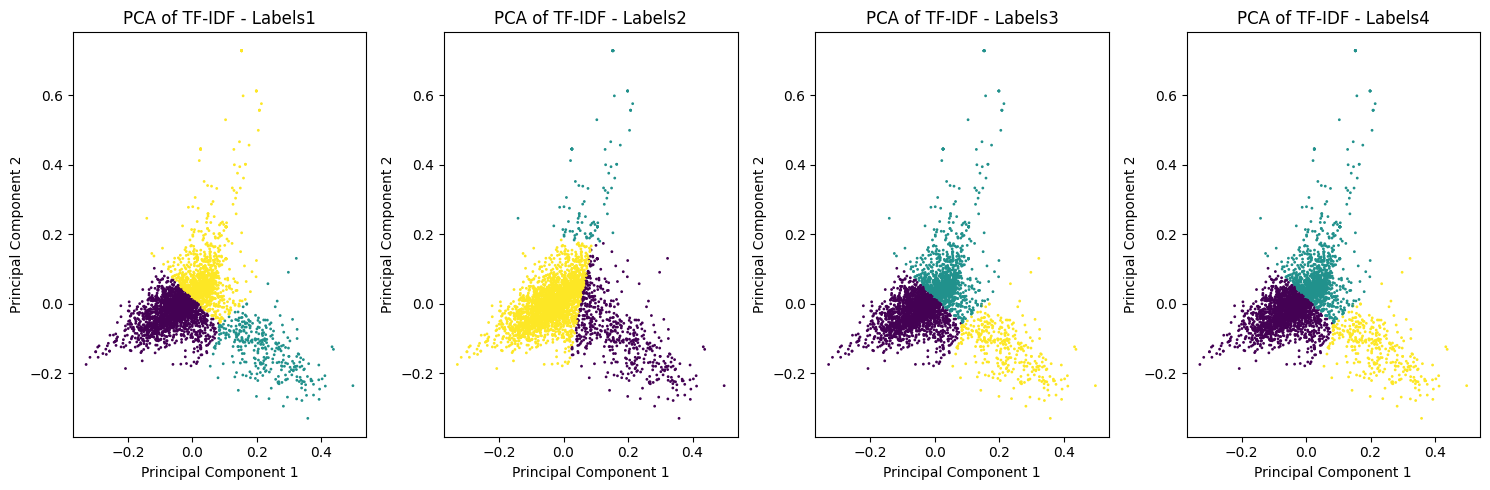

In [50]:
# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot for labels1
axes[0].scatter(tfidf_pca[:, 0], tfidf_pca[:, 1], c=labels1, cmap='viridis', s=1)
axes[0].set_title('PCA of TF-IDF - Labels1')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')

# Plot for labels2
axes[1].scatter(tfidf_pca[:, 0], tfidf_pca[:, 1], c=labels2, cmap='viridis', s=1)
axes[1].set_title('PCA of TF-IDF - Labels2')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')

# Plot for labels3
axes[2].scatter(tfidf_pca[:, 0], tfidf_pca[:, 1], c=labels3, cmap='viridis', s=1)
axes[2].set_title('PCA of TF-IDF - Labels3')
axes[2].set_xlabel('Principal Component 1')
axes[2].set_ylabel('Principal Component 2')

# Plot for labels3
axes[3].scatter(tfidf_pca[:, 0], tfidf_pca[:, 1], c=labels4, cmap='viridis', s=1)
axes[3].set_title('PCA of TF-IDF - Labels4')
axes[3].set_xlabel('Principal Component 1')
axes[3].set_ylabel('Principal Component 2')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [51]:
cpu_percent1,cpu_percent2,cpu_percent3,cpu_percent4

(9.1, 5.4, 6.5, 13.9)

In [52]:
runtime1,runtime2,runtime3,runtime4

(0.01204371452331543,
 0.0879817008972168,
 0.05199146270751953,
 0.28098201751708984)